In [1]:

import os, sys, subprocess, time, toml
import pandas as pd
from MOASMO_parameters import generate_initial_parameter_sets, surrogate_model_train_and_pareto_points, surrogate_model_train_and_pareto_points_experiment, surrogate_model_train_and_pareto_points_oneobjfunc
import run_multiple_paramsets_Derecho


In [2]:
config_file = '/glade/work/guoqiang/CTSM_CAMELS/Calib_HH_MOASMO_bigrange/configuration/_level1-0_config_MOASMO.toml'
config = toml.load(config_file)
iter_end = 1

In [4]:

objfunc = 'oneobjfunc' # twoerror, oneobjfunc, norm2err
print('Objective function is ', objfunc)

# inputs
file_parameter_list = config['file_calib_param']
path_CTSM_base = config['path_CTSM_case']
path_script_MOASMO = config['path_script_MOASMO']
path_CTSM_source = config['path_CTSM_source']
ref_streamflow = config['file_Qobs']

if 'add_flow_file' in config:
    add_flow_file = config['add_flow_file']
else:
    add_flow_file = 'NA'

script_singlerun = f'{path_script_MOASMO}/run_one_paramset_Derecho.py'
script_clone = f'{path_CTSM_source}/cime/scripts/create_clone'


# outputs
if config['path_calib'] == 'NA':
    path_MOASMOcalib = f'{path_CTSM_base}_MOASMOcalib'
else:
    path_MOASMOcalib = config['path_calib']

if objfunc == 'twoerror':
    path_paramset = f'{path_MOASMOcalib}/param_sets'
    path_submit = f'{path_MOASMOcalib}/run_model'
    path_archive = f'{path_MOASMOcalib}/ctsm_outputs'
elif objfunc == 'oneobjfunc':
    path_paramset = f'{path_MOASMOcalib}/param_sets_normKGE2'
    path_submit = f'{path_MOASMOcalib}/run_model_normKGE'
    path_archive = f'{path_MOASMOcalib}/ctsm_outputs_normKGE'   
elif objfunc == 'norm2err':
    path_paramset = f'{path_MOASMOcalib}/param_sets_norm2err'
    path_submit = f'{path_MOASMOcalib}/run_model_norm2err'
    path_archive = f'{path_MOASMOcalib}/ctsm_outputs_norm2err'
    
os.makedirs(path_MOASMOcalib, exist_ok=True)

# MO-ASMO parameters
sampling_method = config['sampling_method']
num_init = config['num_init'] # initial number of samples
num_per_iter = config['num_per_iter'] # number of selected pareto parameter sets for each iteration
num_per_iter = 100
num_iter = config['num_iter'] # including the initial iteration

# evaluation period
RUN_STARTDATE = config['RUN_STARTDATE']
ignore_month = config['ignore_month']
STOP_OPTION = config['STOP_OPTION']
STOP_N = config['STOP_N']

if 'nonstandard_evaluation' in config:
    nonstandard_evaluation = config['nonstandard_evaluation']
else:
    nonstandard_evaluation = 'NA'

# HPC job settings
job_mode = config['job_mode']
job_CTSMiteration = config['job_CTSMiteration']
# job_controlMOASMO = config['job_controlMOASMO'] # not needed here

date_start = (pd.Timestamp(RUN_STARTDATE) + pd.offsets.DateOffset(months=ignore_month)).strftime('%Y-%m-%d') # ignor the first year when evaluating model
if STOP_OPTION == 'nyears':
    date_end = (pd.Timestamp(RUN_STARTDATE) + pd.offsets.DateOffset(years=STOP_N)).strftime('%Y-%m-%d')
elif STOP_OPTION == 'nmonths':
    date_end = (pd.Timestamp(RUN_STARTDATE) + pd.offsets.DateOffset(months=STOP_N)).strftime('%Y-%m-%d')
else:
    sys.exit(f'STOP_OPTION must be nyears or nmonths. {STOP_OPTION} is not accepted.')


# # inputs
# file_parameter_list = '/glade/u/home/guoqiang/CTSM_repos/moasmo_test/param_ASG_20221206_moasmo.csv'
# path_CTSM_base = '/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest_LMWG/CAMELS_100'
# script_singlerun = '/glade/u/home/guoqiang/CTSM_repos/moasmo_test/run_one_paramset.py'
# script_clone = '/glade/u/home/guoqiang/CTSM_repos/CTSM/cime/scripts/create_clone'
# ref_streamflow = '/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest_LMWG/CAMELS_100_OstCalib/refdata/streamflow_data.csv'
# add_flow_file = 'nofile'
#
# # outputs
# path_paramset = '/glade/scratch/guoqiang/moasmo_camels100/param_sets'
# path_submit = '/glade/scratch/guoqiang/moasmo_camels100/run_model'
# path_archive = '/glade/scratch/guoqiang/moasmo_camels100/ctsm_outputs'
#
# # evaluation period
# date_start = '1994-10-01'
# date_end = '1998-09-30'
#
# # MO-ASMO parameters
# sampling_method = 'glp'
# num_init = 36 # initial number of samples
# num_per_iter = 20 # number of selected pareto parameter sets for each iteration
# num_iter = 4 # including the initial iteration
# cpus_per_iter = 36 # how many cpus are used to run each iteration (i.e., the number of cpus of an entire node)

########################################################################################################################
# MO-ASMO main

file_metric_all = []
file_param_all = []

t1 = time.time()
for it in range(0, iter_end):
    print('#'*50)
    print(f'Start iterattion {it}. Total iteration number: {num_iter}')
    

    iterflag = it

    if it == 0:
        sample_num = num_init
    else:
        sample_num = num_per_iter

    file_metric_iter, file_param_iter = run_multiple_paramsets_Derecho.check_if_all_runs_are_finsihed(path_archive, iterflag, sample_num)
    file_metric_all.append(file_metric_iter)
    file_param_all.append(file_param_iter)

# train a surrogate model and select pareto parameter sets
if objfunc == 'twoerror':
    surrogate_model_train_and_pareto_points(file_parameter_list, file_param_all, file_metric_all, path_paramset, iterflag, num_per_iter, path_CTSM_base)
elif objfunc == 'norm2err':
    surrogate_model_train_and_pareto_points(file_parameter_list, file_param_all, file_metric_all, path_paramset, iterflag, num_per_iter, path_CTSM_base, normalize_y=True)
elif objfunc == 'oneobjfunc':
    # ad-hoc change
    file_metric_all = [i.replace('all_metric.csv', 'many_metric.csv') for i in file_metric_all]
    surrogate_model_train_and_pareto_points_oneobjfunc(file_parameter_list, file_param_all, file_metric_all, path_paramset, iterflag, num_per_iter, path_CTSM_base)

# innums = [320, 380, 440, 500, 560] # from iter 0 to 1, 2, ...
# print('using innum', innums[iter_end-1])
# surrogate_model_train_and_pareto_points_experiment(file_parameter_list, file_param_all, file_metric_all, path_paramset, iterflag, num_per_iter, path_CTSM_base, innums[iter_end-1])


# generate submission commands (note, this won't submit a real job on Derecho)
run_multiple_paramsets_Derecho.generate_and_submit_multi_CTSM_runs(iter_end, path_submit, path_paramset, path_CTSM_base, 
                                                                   path_archive, script_singlerun, script_clone, 
                                                                   date_start, date_end, ref_streamflow, add_flow_file,
                                                                   job_CTSMiteration, job_mode)


t2 = time.time()
print(f'Iteration {it} is complete. Time cost (s) is {t2 - t1}')


Objective function is  oneobjfunc
##################################################
Start iterattion 0. Total iteration number: 8
GPR CV KGE Score for metric1/metric2:
   Fold     rmse1
0     1  0.052727
1     2  0.068659
2     3  0.055551
3     4  0.056137
4     5  0.057918
5  mean  0.058198
RF CV KGE Score for metric1/metric2:
   Fold     rmse1
0     1  0.052559
1     2  0.067514
2     3  0.050818
3     4  0.061633
4     5  0.059258
5  mean  0.058356
Use GPR model
Load default parameter values from: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_0_MOASMOcalib/param_sets_normKGE2/all_default_parameters.pkl
Generating parameter file: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_0_MOASMOcalib/param_sets_normKGE2/paramset_iter1_trial0.pkl
Generating parameter file: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_0_MOASMOcalib/param_sets_normKGE2/paramset_iter1_t

In [44]:
import numpy as np
v = []
b = 13
for i in range(40):
    df1 = pd.read_pickle(f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{b}_MOASMOcalib/param_sets_normKGE2/paramset_iter1_trial{i}.pkl')
    df2 = pd.read_pickle(f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{b}_MOASMOcalib/param_sets_normKGE/paramset_iter1_trial{i}.pkl')
    v1 = np.array([ np.mean(i) for i in df1['Value'] ] )
    v2 = np.array([ np.mean(i) for i in df2['Value'] ] )
    v.append(v1)
    if np.any( np.abs(v1/v2-1) > 0.01):
        print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [46]:
v=np.array(v)

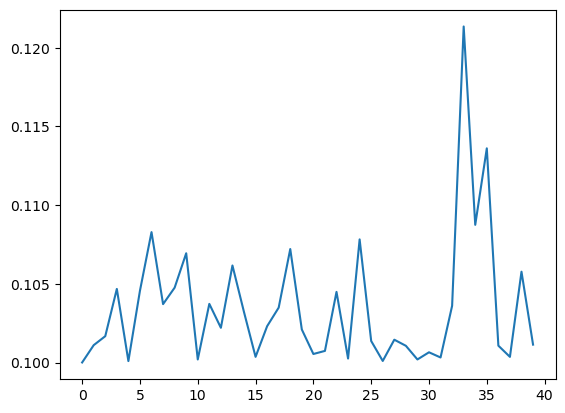

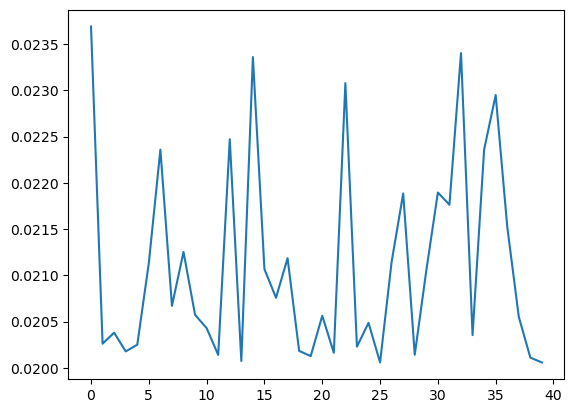

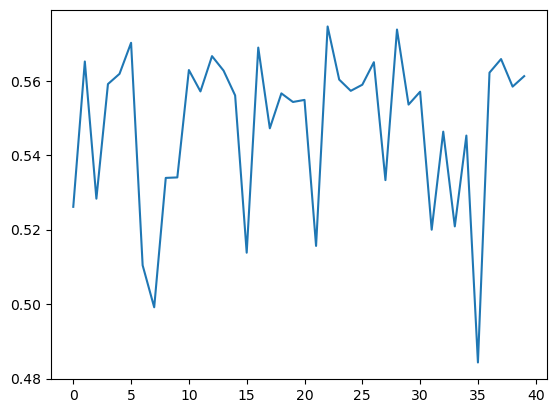

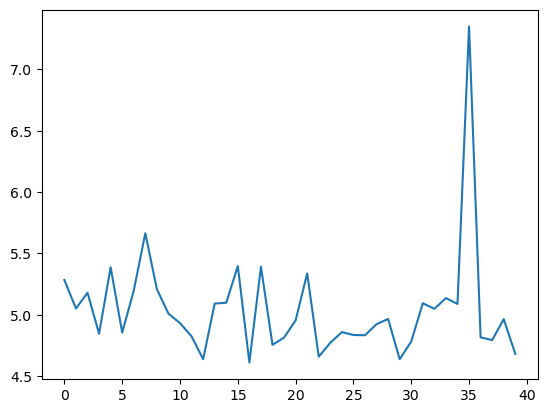

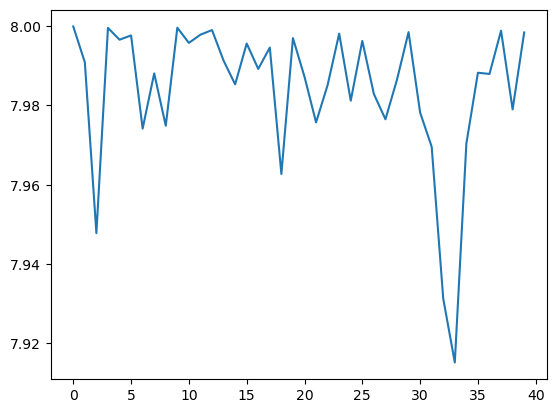

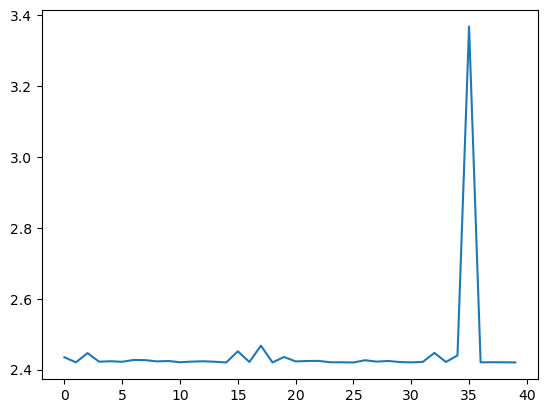

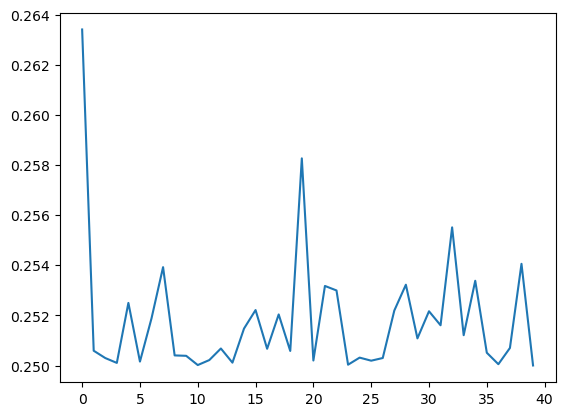

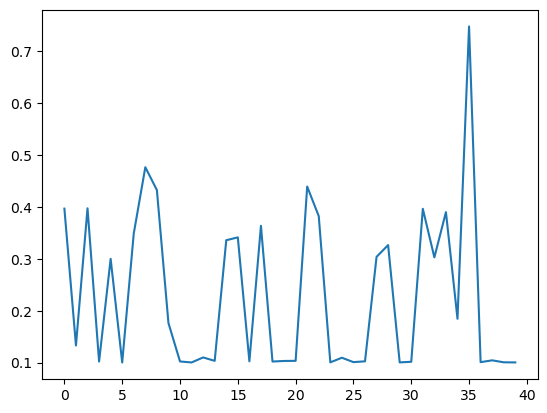

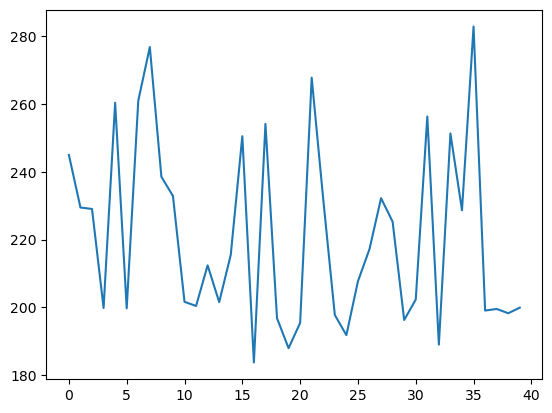

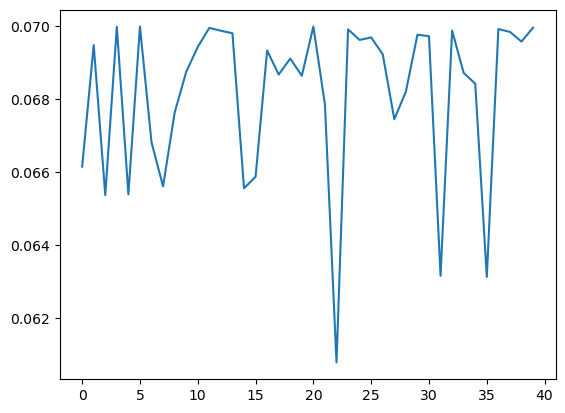

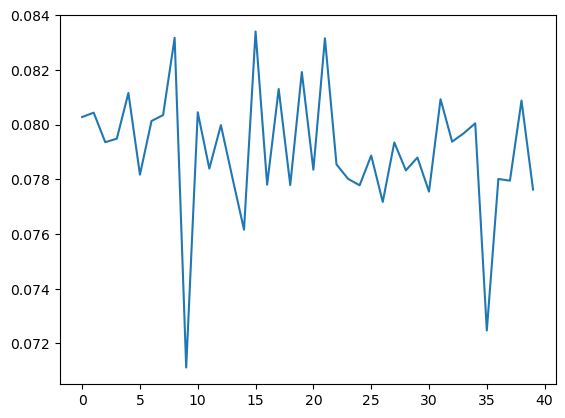

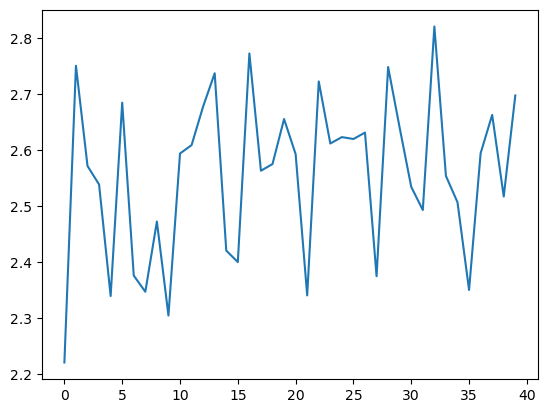

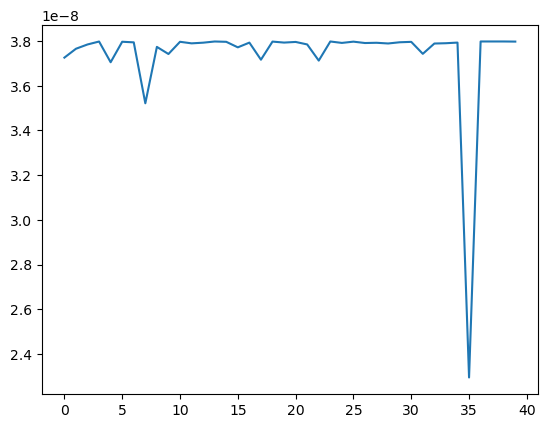

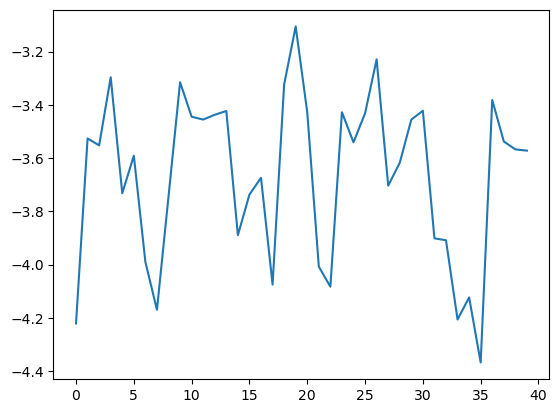

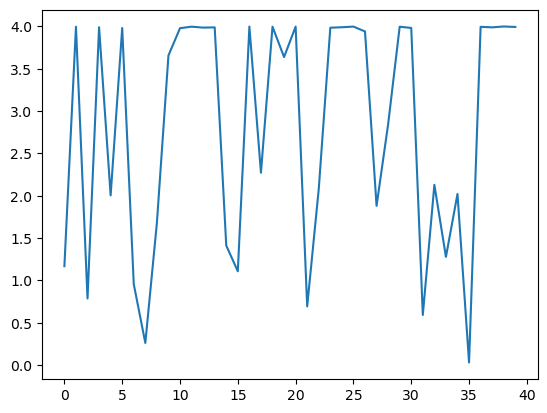

In [47]:
for i in range(v.shape[1]):
    plt.figure()
    plt.plot(v[:,i])